# QOSF Mentorship Program Screening Tasks

## Task 2 Noise, Noise, and More Noise

One of the main challenges in quantum computing is the noise in current devices. In this task, you will create a simple noise generator and assess its effect. You can use any framework you like (Qiskit, Cirq, etc..)

### 1. Noise Model
A standard way to represent the noise in a quantum circuit is through Pauli operators $(\sigma_x, \sigma_y, \sigma_z)$. Build a function with input $\alpha$, $ \beta $ and `QuantumCircuit` where:
- $\alpha \to$ Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
- $\beta \to$ Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
- `QuantumCircuit` $\to$ where the noise will be added
The output should be the Quantum Circuit with Noise 

Import Necessary Modules:

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline

Define the Noise Function:

In [2]:
def add_noise(a, b, quantum_circuit):
    noise_model = NoiseModel()
    
    # Define the noise for single qubit gates
    pauli_1q = pauli_error([('X', a/3), ('Y', a/3), ('Z', a/3), ('I', 1 - a)])
    
    # Define the noise for two qubit gates
    pauli_2q = pauli_error([('IX', b/15), ('IY', b/15), ('IZ', b/15),
                            ('XI', b/15), ('XX', b/15), ('XY', b/15), ('XZ', b/15),
                            ('YI', b/15), ('YX', b/15), ('YY', b/15), ('YZ', b/15),
                            ('ZI', b/15), ('ZX', b/15), ('ZY', b/15), ('ZZ', b/15),
                            ('II', 1 - b)])
        
    # Add noise to all single qubit gates
    for gate in ['id', 'rz', 'sx', 'x']:
        noise_model.add_all_qubit_quantum_error(pauli_1q, gate)
    
    # Add noise to all two qubit gates
    noise_model.add_all_qubit_quantum_error(pauli_2q, 'cx')
    
    return noise_model

### 2. Gate Basis
Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: `{CX,ID,RZ,SX,X}`

In [3]:
def transform_to_basis(qc):
    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    pass_manager = PassManager(BasisTranslator(SessionEquivalenceLibrary, basis_gates))
    transformed_circuit = pass_manager.run(qc)
    return transformed_circuit

### 3. Adding two numbers with a quantum computer
Build a function (`quantum_sum`) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.

In [5]:
# def qft(n):
#     """Create a quantum circuit implementing the QFT over n qubits."""
#     qc = QuantumCircuit(n)
#     for j in range(n):
#         # Apply the Hadamard gate
#         qc.h(j)
#         # Apply controlled phase rotations
#         for k in range(j+1, n):
#             angle = np.pi / (2**(k - j))
#             qc.cp(angle, k, j)
#         # Swap qubits to reverse the order
#     # Swap qubits to reverse the order
#     for i in range(n//2):
#         qc.swap(i, n-i-1)
#     return qc

def qft(circuit, qubits):
    """Apply the QFT on the specified qubits in the circuit."""
    n = len(qubits)
    for j in range(n):
        circuit.h(qubits[j])
        for k in range(j+1, n):
            angle = np.pi / 2**(k - j)
            circuit.cp(angle, qubits[k], qubits[j])
    # Include SWAP gates to reverse the qubit order
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])

In [6]:
# def inverse_qft(n):
#     """Create a quantum circuit implementing the inverse QFT over n qubits."""
#     qc = QuantumCircuit(n)
#     # Apply the inverse QFT operations
#     for j in reversed(range(n)):
#         # Swap qubits to reverse the order
#         for i in range(n//2):
#             qc.swap(i, n-i-1)
#         # Apply controlled phase rotations
#         for k in range(j+1, n):
#             angle = -np.pi / (2**(k - j))
#             qc.cp(angle, k, j)
#         # Apply the Hadamard gate
#         qc.h(j)
#     return qc

def inverse_qft(circuit, qubits):
    """Apply the inverse QFT on the specified qubits in the circuit."""
    n = len(qubits)
    # Include SWAP gates to reverse the qubit order
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])
    for j in reversed(range(n)):
        for k in range(j+1, n):
            angle = -np.pi / 2**(k - j)
            circuit.cp(angle, qubits[k], qubits[j])
        circuit.h(qubits[j])

In [7]:
def quantum_sum(a, b, n):
    qr_a = QuantumRegister(n, name='a')  # Register to store 'a' and the result
    qr_b = QuantumRegister(n, name='b')  # Register to store 'b'
    cr = ClassicalRegister(n, name='result')  # Classical register for measurement
    
    qc = QuantumCircuit(qr_a, qr_b, cr)
    
    # Initialize the qubits with the binary representation of the numbers
    # for i in range(n):
    #     if (a >> i) & 1:
    #         qc.x(i)
    #     if (b >> i) & 1:
    #         qc.x(i + n)

    # Initialize Register A with the value 'a'
    a_binary = format(a, f'0{n}b')
    for idx, bit in enumerate(reversed(a_binary)):
        if bit == '1':
            qc.x(qr_a[idx])

    # Initialize Register B with the value 'b'
    b_binary = format(b, f'0{n}b')
    for idx, bit in enumerate(reversed(b_binary)):
        if bit == '1':
            qc.x(qr_b[idx])
    
    # Apply QFT to Register A
    qft(qc, qr_a)
    
    # Apply controlled phase shifts based on Register B
    for i in range(n):          # Loop over qubits in Register B
        for j in range(n):      # Loop over qubits in Register A
            if i <= j:
                angle = (2 * np.pi) / (2 ** (j - i + 1))
                qc.cp(angle, qr_b[i], qr_a[j])

    # Apply inverse QFT to Register A
    inverse_qft(qc, qr_a)

    # Measure Register A to get the result
    qc.measure(qr_a, cr)
    
    return qc

### 4. Effects of noise on quantum addition
Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 
- How does the noise affect the results?
- Is there a way to decrease the effect of noise?
- How does the number of gates used affect the results?

In [10]:
def analyze_quantum_addition(a, b, num_a, num_b, n):
    qc = quantum_sum(num_a, num_b, n)
    transformed_qc = transform_to_basis(qc)
    noise_model = add_noise(a, b, transformed_qc)
    
    # Simulate the circuit with noise
    simulator = AerSimulator()
    transpiled_qc = transpile(transformed_qc, simulator)
    result = simulator.run(transpiled_qc, noise_model=noise_model, shots=1024).result()
    counts = result.get_counts(0)
    
    return counts

Noise levels: a=0, b=0
{'1000': 1024}


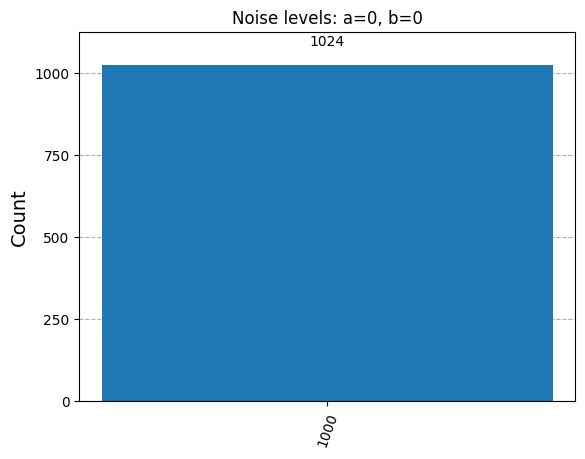

Noise levels: a=0, b=0.1
{'0000': 65, '1001': 69, '0101': 45, '0010': 66, '1010': 64, '1011': 78, '0111': 60, '1000': 91, '1110': 60, '0110': 51, '0011': 55, '0001': 60, '1100': 73, '0100': 58, '1111': 57, '1101': 72}


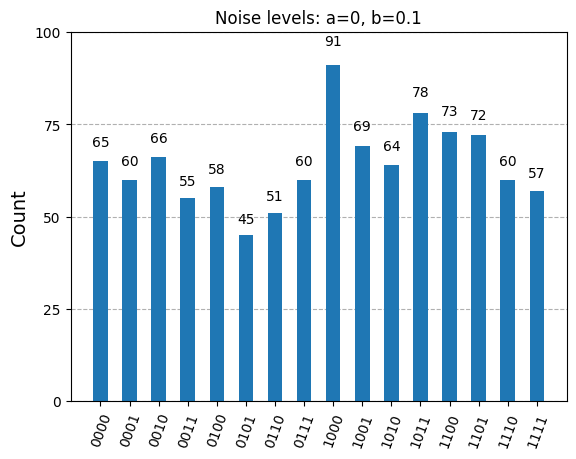

Noise levels: a=0, b=0.2
{'0110': 65, '1000': 64, '1010': 63, '1001': 59, '1011': 49, '0101': 73, '1110': 63, '0100': 61, '1100': 64, '0111': 64, '0001': 62, '0011': 62, '1101': 78, '1111': 65, '0010': 55, '0000': 77}


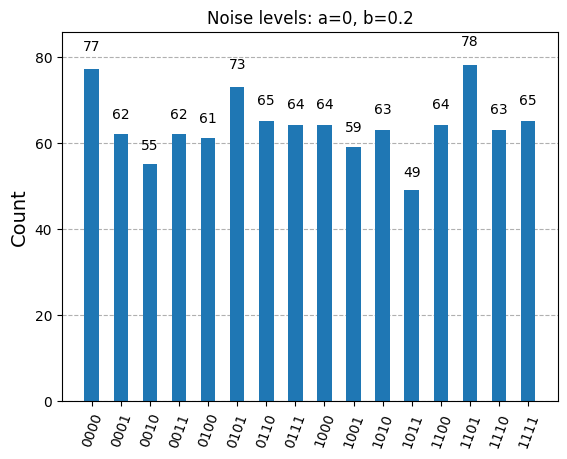

Noise levels: a=0, b=0.3
{'1000': 56, '1110': 66, '0100': 58, '1100': 70, '1101': 55, '1111': 63, '0111': 75, '1010': 77, '1001': 74, '1011': 48, '0000': 46, '0010': 72, '0011': 66, '0001': 75, '0110': 56, '0101': 67}


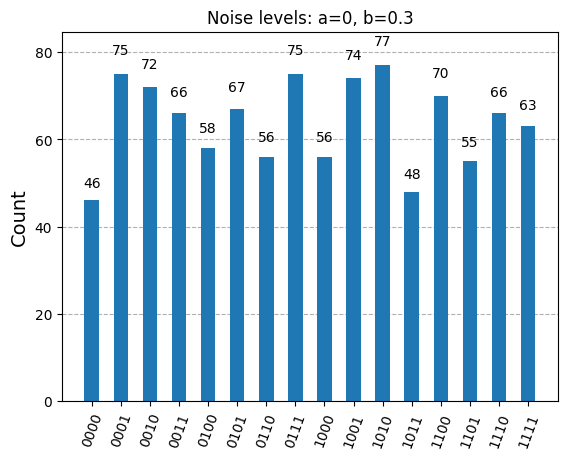

Noise levels: a=0.1, b=0
{'1001': 90, '0110': 39, '0111': 36, '1010': 74, '0101': 49, '1011': 110, '1110': 67, '1000': 111, '1100': 75, '0100': 45, '0000': 52, '0010': 41, '0001': 44, '0011': 35, '1101': 75, '1111': 81}


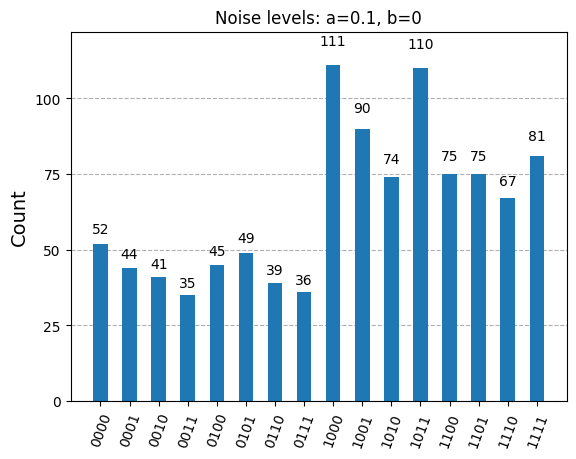

Noise levels: a=0.1, b=0.1
{'0111': 59, '1011': 64, '0010': 78, '1001': 76, '1010': 65, '0101': 72, '0000': 57, '1000': 72, '0100': 71, '1100': 60, '1110': 66, '0110': 53, '0011': 59, '0001': 54, '1101': 62, '1111': 56}


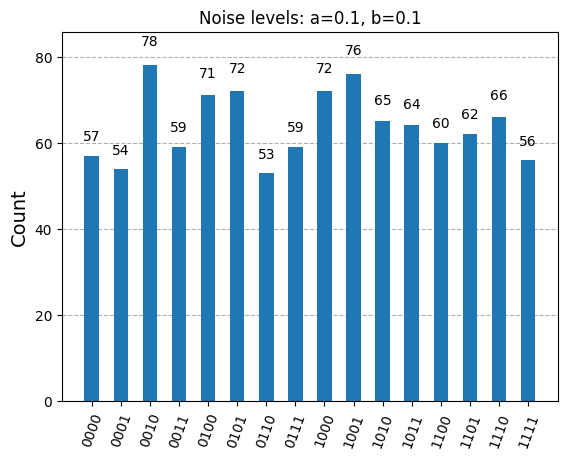

Noise levels: a=0.1, b=0.2
{'1100': 60, '0100': 50, '0010': 76, '1011': 69, '0111': 79, '1111': 61, '1101': 63, '0101': 55, '1010': 68, '0001': 66, '0011': 57, '1001': 72, '0110': 59, '1000': 68, '1110': 61, '0000': 60}


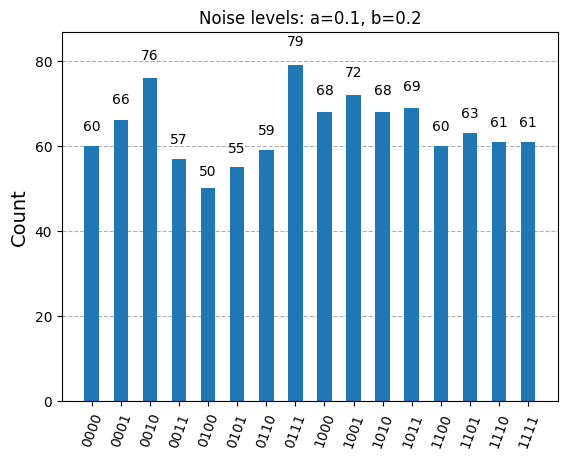

Noise levels: a=0.1, b=0.3
{'1011': 69, '0000': 60, '0001': 79, '0011': 73, '0010': 67, '0101': 57, '1111': 56, '1101': 68, '1100': 61, '0100': 60, '0110': 68, '1000': 62, '1110': 63, '1010': 60, '0111': 65, '1001': 56}


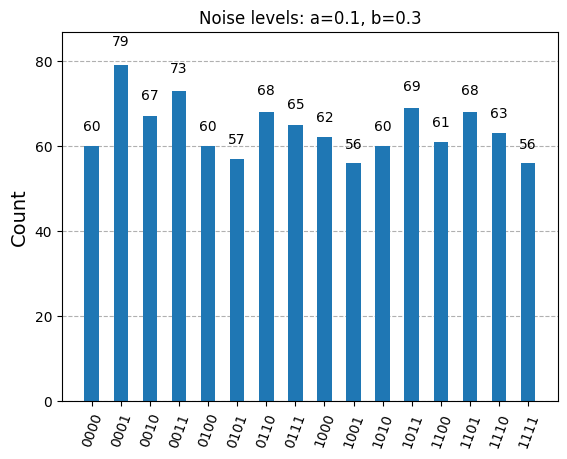

Noise levels: a=0.2, b=0
{'0010': 50, '1010': 69, '0000': 56, '1001': 69, '1011': 77, '1101': 70, '1111': 69, '0111': 60, '0100': 62, '1100': 69, '1110': 72, '1000': 70, '0101': 52, '0110': 56, '0011': 73, '0001': 50}


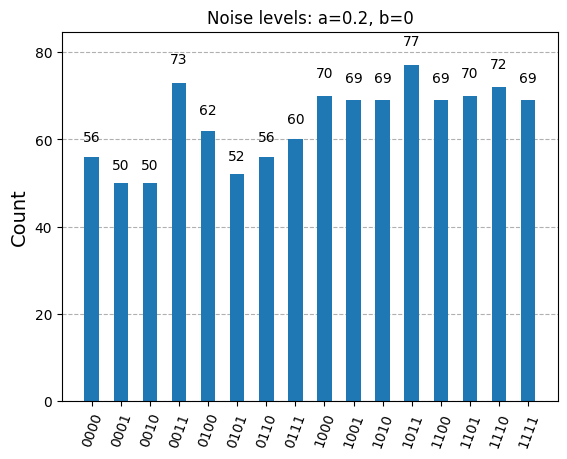

Noise levels: a=0.2, b=0.1
{'0111': 55, '0101': 56, '0110': 63, '1010': 72, '0000': 54, '0010': 69, '0011': 70, '0001': 63, '1011': 67, '1000': 60, '0100': 69, '1100': 49, '1110': 69, '1001': 67, '1111': 67, '1101': 74}


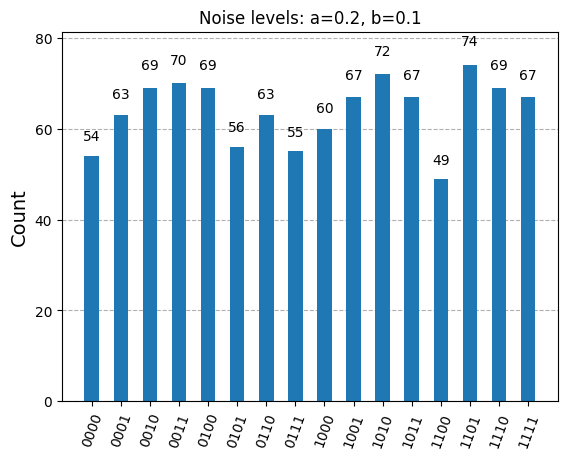

Noise levels: a=0.2, b=0.2
{'0010': 47, '0101': 65, '1010': 62, '1011': 63, '0001': 60, '0011': 51, '0111': 79, '0000': 59, '1111': 64, '1101': 62, '0110': 61, '1110': 72, '1000': 71, '0100': 77, '1100': 68, '1001': 63}


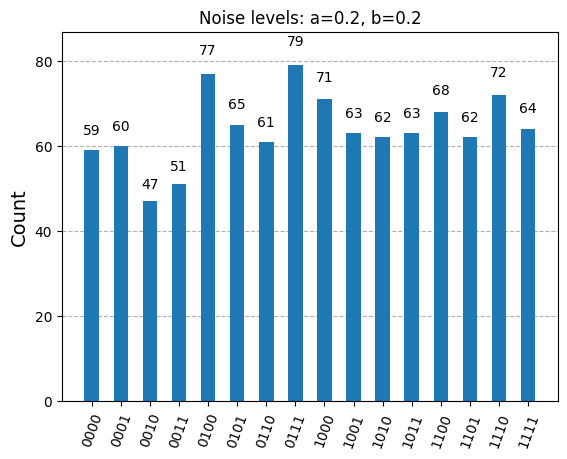

Noise levels: a=0.2, b=0.3
{'0111': 59, '1011': 56, '0101': 65, '1010': 73, '1111': 66, '1101': 75, '1001': 62, '0011': 55, '0001': 63, '1100': 73, '0100': 62, '0110': 60, '1110': 72, '1000': 63, '0000': 59, '0010': 61}


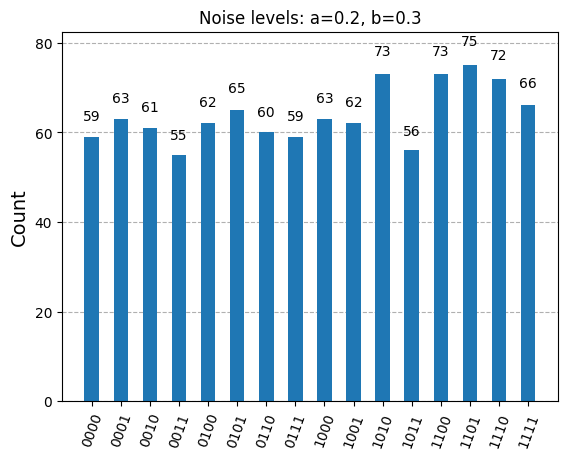

Noise levels: a=0.3, b=0
{'1110': 50, '1001': 73, '0000': 63, '1000': 54, '0101': 66, '1011': 61, '0010': 66, '0001': 72, '0011': 57, '1101': 70, '1111': 74, '0111': 55, '0110': 66, '1100': 64, '0100': 61, '1010': 72}


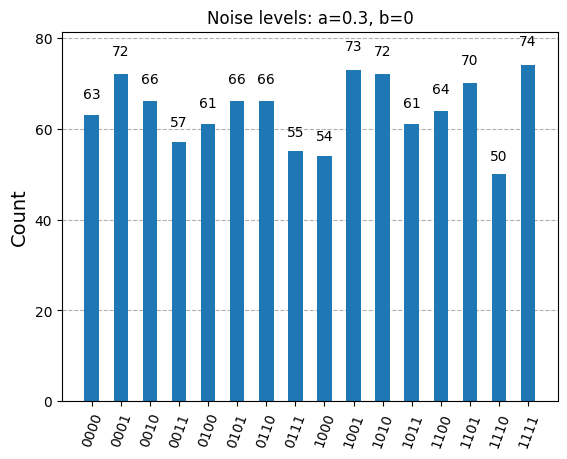

Noise levels: a=0.3, b=0.1
{'0010': 64, '1110': 77, '1011': 60, '1001': 64, '1111': 71, '1101': 58, '0000': 71, '1010': 70, '0100': 46, '1100': 65, '1000': 66, '0111': 46, '0001': 64, '0011': 62, '0110': 71, '0101': 69}


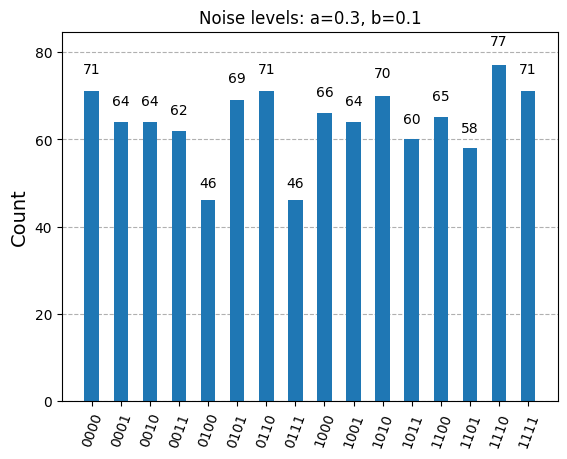

Noise levels: a=0.3, b=0.2
{'1110': 63, '1000': 53, '1001': 75, '1010': 68, '0100': 64, '1100': 63, '1011': 65, '0101': 72, '0110': 74, '0011': 60, '0001': 68, '0111': 63, '1101': 56, '1111': 54, '0010': 64, '0000': 62}


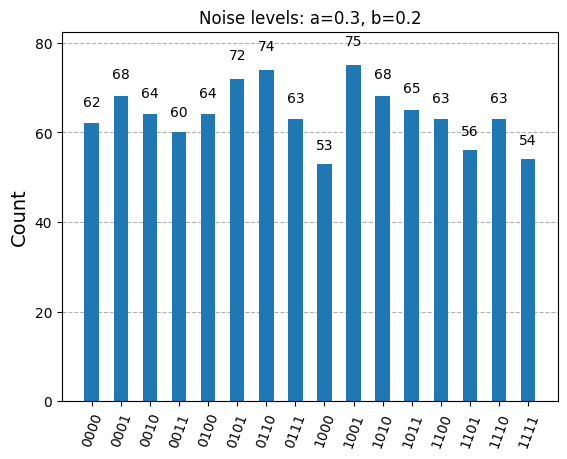

Noise levels: a=0.3, b=0.3
{'0000': 70, '0010': 62, '0111': 75, '1011': 66, '0101': 59, '0001': 67, '0011': 59, '1010': 56, '1000': 43, '0100': 59, '1100': 61, '1110': 76, '0110': 70, '1111': 68, '1101': 56, '1001': 77}


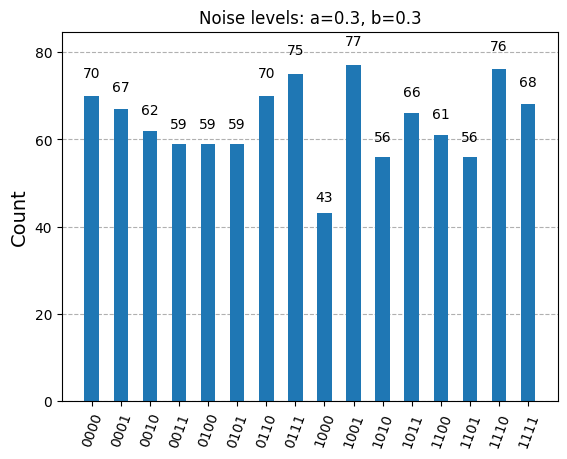

In [15]:
a_values = [0, 0.1, 0.2, 0.3]
b_values = [0, 0.1, 0.2, 0.3]
num_a = 3
num_b = 5
n = 4  # Number of qubits to represent the numbers

for a in a_values:
    for b in b_values:
        counts = analyze_quantum_addition(a, b, num_a, num_b, n)
        print(f"Noise levels: a={a}, b={b}")
        print(counts)

        # Plot the histogram
        plot_histogram(counts, title=f"Noise levels: a={a}, b={b}")
        plt.show()